## Cal-CRAI Metric Calculation for: Climate Risk / Wildfire warnings
* Median annual number of days with red flag warnings

In [1]:
import geopandas as gpd
import s3fs
import pandas as pd
import boto3
import dask_geopandas
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata

### The biggest dataset: ISU Mesonet's wildfire warning database

In [2]:
# make a list of paths, since this is actually 10 files
def build_isu_mesonet_file_list(
    path='2b_reproject/climate_risk/wildfire/exposure/historical/iowa_state_environmental_mesonet'
):
    """ Build a list of shapefile URIs contained in S3 folder """
    # initiate empty list for s3 URIs
    all_shapefiles = []
    bucket_name = 'ca-climate-index' 
    # initiate s3 session
    session = boto3.Session()
    # use the session to get the resource
    s3 = session.resource('s3')
    my_bucket = s3.Bucket(bucket_name)
    # iterate through directory
    for obj in my_bucket.objects.filter(
        Prefix=path):
        all_shapefiles.append(obj.key)
    return all_shapefiles

In [3]:
build_isu_mesonet_file_list()

['2b_reproject/climate_risk/wildfire/exposure/historical/iowa_state_environmental_mesonet/climate_iowa_mesonet_wildfire_warnings.parquet.gzip/part.0.parquet',
 '2b_reproject/climate_risk/wildfire/exposure/historical/iowa_state_environmental_mesonet/climate_iowa_mesonet_wildfire_warnings.parquet.gzip/part.1.parquet',
 '2b_reproject/climate_risk/wildfire/exposure/historical/iowa_state_environmental_mesonet/climate_iowa_mesonet_wildfire_warnings.parquet.gzip/part.2.parquet',
 '2b_reproject/climate_risk/wildfire/exposure/historical/iowa_state_environmental_mesonet/climate_iowa_mesonet_wildfire_warnings.parquet.gzip/part.3.parquet',
 '2b_reproject/climate_risk/wildfire/exposure/historical/iowa_state_environmental_mesonet/climate_iowa_mesonet_wildfire_warnings.parquet.gzip/part.4.parquet',
 '2b_reproject/climate_risk/wildfire/exposure/historical/iowa_state_environmental_mesonet/climate_iowa_mesonet_wildfire_warnings.parquet.gzip/part.5.parquet',
 '2b_reproject/climate_risk/wildfire/exposure/

In [4]:
pqt_list = build_isu_mesonet_file_list()
path = '2b_reproject/climate_risk/wildfire/exposure/historical/iowa_state_environmental_mesonet' 
to_drop = ['hilbert_distance', 'WFO', 'EXPIRED', 'INIT_ISS', 'INIT_EXP',
       'PHENOM', 'GTYPE', 'SIG', 'ETN', 'STATUS', 'NWS_UGC',
       'UPDATED', 'HV_NWSLI', 'HV_SEV', 'HV_CAUSE', 'HV_REC', 
       'POLY_BEG', 'POLY_END', 'WINDTAG', 'HAILTAG', 'TORNTAG', 
        'DAMAGTAG', 'index_right', 'USCB_NAME','AREA_KM2','EMERGENC',
          'geometry']
bucket = 'ca-climate-index'

df_list = []
for f in pqt_list:
    bucket_uri = f's3://{bucket}/{f}'
    # read in as dask geopandas dataframe
    df = dask_geopandas.read_parquet(bucket_uri)
    # reduce memory use by dropping unneeded columns
    df = df.drop(columns=to_drop)
    # reduce by counting the # of events per tract:
    # shave off time issued so we only have days    
    df['ISSUED_day'] = df['ISSUED'].str.slice(0,8)
    df = df.drop_duplicates(subset=['ISSUED_day', 'USCB_GEOID'], keep='first')
    df['ISSUED_year'] = df['ISSUED'].str.slice(0,4)
    df_out = df.groupby(
        ['USCB_GEOID','ISSUED_day']
    )['ISSUED'].count().compute().reset_index(
    ).rename(columns={'ISSUED':'number_warnings'})
    # append df_out to the list of dfs
    df_list.append(df_out)
    # clear memory
    df_out = None

In [5]:
df_merged = pd.concat(df_list)
# remove more duplicates which are exposed after merging
df_merged = df_merged.drop_duplicates(subset=['ISSUED_day', 'USCB_GEOID'], keep='first')
df_merged['ISSUED_year'] = df_merged['ISSUED_day'].str.slice(0,4)
df_merged

,USCB_GEOID,ISSUED_day,number_warnings,ISSUED_year
0,06001400100,20060922,1,2006
1,06001400100,20061010,1,2006
2,06001400100,20061021,1,2006
3,06001400100,20061025,1,2006
4,06001400100,20070710,1,2007
...,...,...,...,...
52271,06111009500,20221119,1,2022
52272,06111009500,20221124,1,2022
52273,06111009500,20231029,1,2023
52274,06111009500,20231109,1,2023


In [6]:
dfg = df_merged.groupby(
        ['USCB_GEOID','ISSUED_year']).count()
dfg = dfg.drop(columns='ISSUED_day').unstack()
dfg

number_warnings                                                  \
ISSUED_year            2006 2007  2008 2009 2010 2011 2012  2013  2014 2015   
USCB_GEOID                                                                    
06001400100             4.0  1.0   6.0  3.0  2.0  3.0  3.0   5.0   3.0  3.0   
06001400200             4.0  1.0   1.0  NaN  NaN  NaN  NaN   NaN   NaN  1.0   
06001400300             4.0  1.0   1.0  NaN  NaN  NaN  NaN   NaN   NaN  1.0   
06001400400             4.0  1.0   1.0  NaN  NaN  NaN  NaN   NaN   NaN  1.0   
06001400500             4.0  1.0   1.0  NaN  NaN  NaN  NaN   NaN   NaN  1.0   
...                     ...  ...   ...  ...  ...  ...  ...   ...   ...  ...   
06115040902             4.0  1.0   7.0  1.0  1.0  1.0  4.0   6.0   5.0  2.0   
06115041001             4.0  1.0   7.0  1.0  1.0  1.0  4.0   6.0   5.0  2.0   
06115041002             5.0  1.0   9.0  3.0  1.0  1.0  6.0   7.0   6.0  2.0   
06115041101             8.0  5.0  13.0  4.0  3.0  2.0  9.0  11.0  11.0  3.0   
06115041102             3.0  NaN   6.0  2.0  NaN  1.0  3.0   2.0   3.0  1.0   

                                                          
ISSUED_year 2016  2017  2018  2019  2020  2021 2022 2023  
USCB_GEOID                                                
06001400100  NaN   9.0   9.0   6.0  10.0   6.0  NaN  1.0  
06001400200  NaN   NaN   NaN   NaN   3.0   NaN  NaN  NaN  
06001400300  NaN   NaN   NaN   NaN   3.0   NaN  NaN  NaN  
06001400400  NaN   NaN   NaN   NaN   3.0   NaN  NaN  NaN  
06001400500  NaN   NaN   NaN   NaN   3.0   NaN  NaN  NaN  
...          ...   ...   ...   ...   ...   ...  ...  ...  
06115040902  3.0  10.0  11.0   9.0  11.0  11.0  4.0  3.0  
06115041001  3.0  10.0  11.0   9.0  11.0  11.0  4.0  3.0  
06115041002  3.0  14.0  14.0  13.0  13.0  13.0  4.0  3.0  
06115041101  5.0  17.0  17.0  15.0  14.0  15.0  5.0  3.0  
06115041102  NaN   6.0   8.0   6.0   6.0   9.0  NaN  NaN  

[9124 rows x 18 columns]

In [7]:
df_agg = pd.DataFrame(dfg.median(axis=1)).reset_index()
df_agg = df_agg.rename(columns={0:"median_warning_days",'USCB_GEOID':'GEOID'}) 
df_agg

,GEOID,median_warning_days
0,06001400100,3.5
1,06001400200,1.0
2,06001400300,1.0
3,06001400400,1.0
4,06001400500,1.0
...,...,...
9119,06115040902,4.0
9120,06115041001,4.0
9121,06115041002,5.5
9122,06115041101,8.5


In [8]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
red_flag_warning_df = pd.merge(df_agg,ca_boundaries,on="GEOID")
red_flag_gdf = gpd.GeoDataFrame(
    red_flag_warning_df, geometry=red_flag_warning_df["geometry"]
)

### Missing island tract, so we merge with 2021 census data which will add the island tract and give it NaN value

In [9]:
island_tract = df_agg[df_agg['GEOID'] == '06075980401']
island_tract

,GEOID,median_warning_days
7293,06075980401,1.0


In [10]:
ca_boundaries = ca_boundaries['GEOID']
ca_boundaries

0       06085504321
1       06085504410
2       06085507003
3       06085507004
4       06085502204
           ...     
9124    06059001303
9125    06059001304
9126    06059001401
9127    06013367200
9128    06037578100
Name: GEOID, Length: 9129, dtype: object

In [11]:
merged_red_flag_data = pd.merge(df_agg, ca_boundaries, on='GEOID', how='right')
merged_red_flag_data

,GEOID,median_warning_days
0,06085504321,1.5
1,06085504410,1.5
2,06085507003,2.0
3,06085507004,1.5
4,06085502204,1.5
...,...,...
9124,06059001303,4.0
9125,06059001304,4.0
9126,06059001401,5.0
9127,06013367200,1.0


In [12]:
merged_red_flag_data.loc[merged_red_flag_data['GEOID'] == '06075980401', 'median_warning_days'] = np.nan
island_tract = merged_red_flag_data[merged_red_flag_data['GEOID'] == '06075980401']
island_tract

,GEOID,median_warning_days
2380,06075980401,NaN


## Visualizing the data

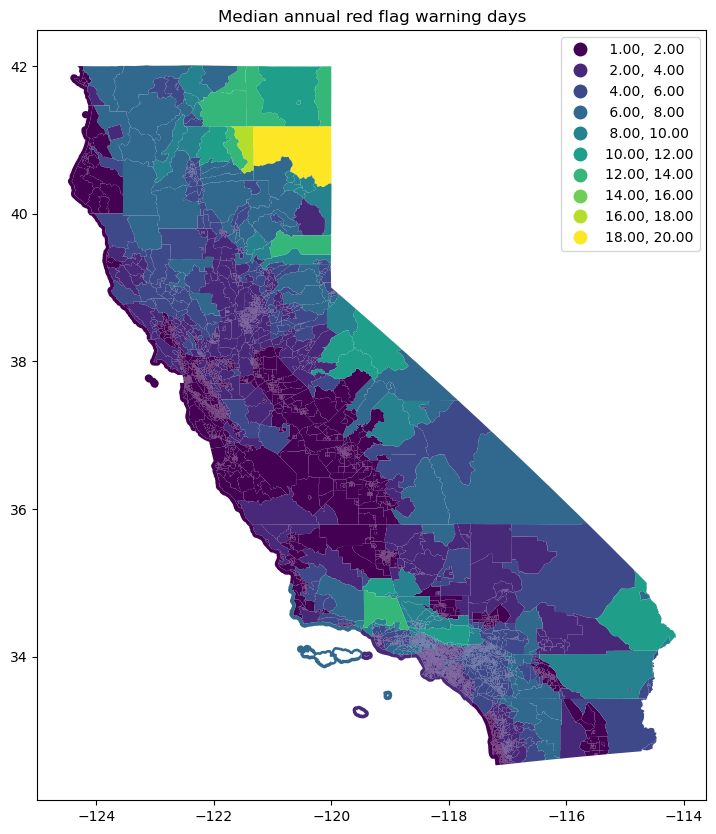

In [13]:
bins = [2,4,6,8,10,12,14,16,18,20]
fig, ax = plt.subplots(figsize=(10,10))
red_flag_gdf.plot(
    column="median_warning_days",
    legend=True,
    ax=ax,
    scheme='user_defined',
    classification_kwds={'bins': bins})
ax.set_title("Median annual red flag warning days")
plt.show()

In [14]:
merged_red_flag_data

,GEOID,median_warning_days
0,06085504321,1.5
1,06085504410,1.5
2,06085507003,2.0
3,06085507004,1.5
4,06085502204,1.5
...,...,...
9124,06059001303,4.0
9125,06059001304,4.0
9126,06059001401,5.0
9127,06013367200,1.0


In [15]:
merged_red_flag_data = merged_red_flag_data.rename(columns={'median_warning_days':'median_red_flag_warning_days'})
merged_red_flag_data.to_csv('climate_wildfire_warning_metric.csv', index=False)

## Function Call

In [16]:
@append_metadata
def isu_red_flag_warning_upload(input_csv, export=False, varname=''):
    '''
    Uploads the calculated wildfire warning metric to S3 bucket. The metric is:
    Median number of red flag warnings days
    
    Data for this metric was sourced from ISU's Environmental Mesonet at:
    https://mesonet.agron.iastate.edu/request/gis/watchwarn.phtml

    Methods
    -------
    Data parquet files were read in and merged together.
    Red flag warning date, location, and count columns were retained.
    Duplicate entries for a given location and date were dropped.
    Data was grouped by location and red flag warning year.
    Number of red flag warnings per year were summed per census tract.
    The median number of red flag warnings were calculated for each census tract.
    
    Parameters
    ----------
    input_csv: string
        csv red flag warning data 
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI red flag warning metric to AWS
        True = will upload resulting df containing CAL CRAI red flag warning metric to AWS

    Script
    ------
    climate_risk_red_flag_warning.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: previously reprojected data parquets were read in and merged together.')
    print('Data transformation: relevant metric columns were isolated.')
    print('Data transformation: duplicate entries per location and date were dropped.')
    print('Data transformation: GEOID 06075980401 (Farallon Islands, San Francisco County) filled with nan.') 
 
    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [input_csv]
        upload_csv_aws(export_filename, bucket_name, directory)

    if export == False:
        print(f'{input_csv} uploaded to AWS.')
 
    if os.path.exists(input_csv):
        os.remove(input_csv)

In [17]:
input_csv = 'climate_wildfire_warning_metric.csv'
varname = 'climate_iowa_mesonet_wildfire_warnings'

isu_red_flag_warning_upload(input_csv, export=True, varname='test')